In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
### READ DATA ###

df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz')
df['date_time'] = pd.to_datetime(df['date_time'])
df.drop_duplicates('date_time', inplace=True)
df.set_index('date_time', inplace=True)

print(df.shape)
df.head()

(40575, 8)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [3]:
### INSERT MISSING DATES ###

df = df.reindex(pd.date_range(df.head(1).index[0], df.tail(1).index[0], freq='H'))

df.shape

(52551, 8)

Text(0, 0.5, 'traffic_volume')

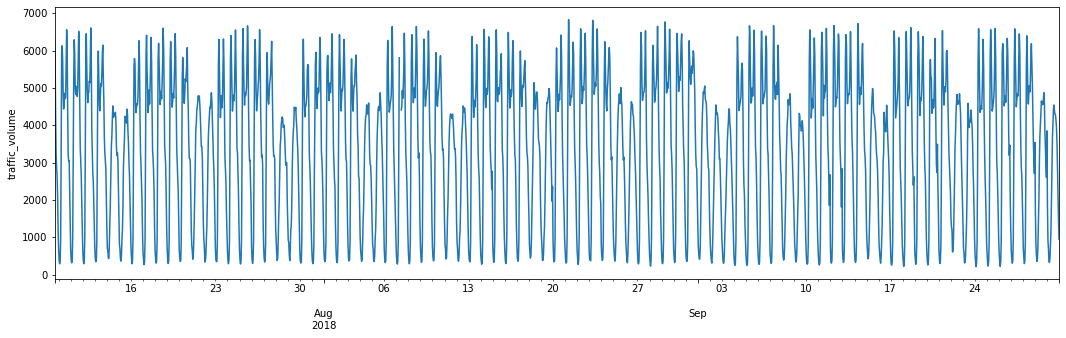

In [4]:
### PLOT TRAFFIC SAMPLE ###

df.traffic_volume.tail(2000).plot(figsize=(18,5))
plt.ylabel('traffic_volume')

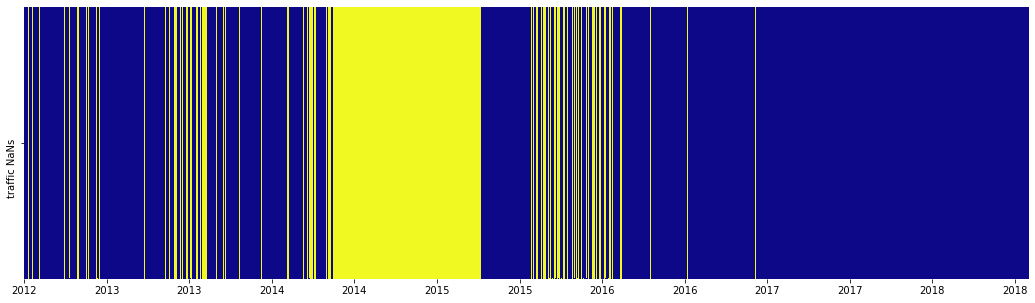

In [5]:
### PLOT MISSING VALUES OVER TIME ###

plt.figure(figsize=(18,5))
sns.heatmap(df[['traffic_volume']].isna().T, cbar=False, cmap='plasma', 
            xticklabels=False, yticklabels=['traffic NaNs'])
plt.xticks(range(0,len(df), 24*180), list(df.index.year[::24*180]))
np.set_printoptions(False)

In [6]:
### FILL MISSING VALUES ###

df = df[df.index.year.isin([2016,2017,2018])].copy()

df = pd.concat([df.select_dtypes(include=['object']).fillna(method='backfill'),
                df.select_dtypes(include=['float']).interpolate()], axis=1)

df.shape

(24096, 8)

Text(0.5, 0, 'month')

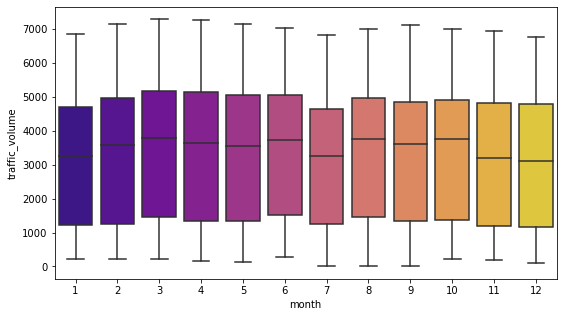

In [7]:
### PLOT TRAFFIC DISTRIBUTION IN EACH MONTH ###

plt.figure(figsize=(9,5))
sns.boxplot(x=df.index.month, y=df.traffic_volume, palette='plasma')

plt.ylabel('traffic_volume'); plt.xlabel('month')

Text(0.5, 0, 'weekday')

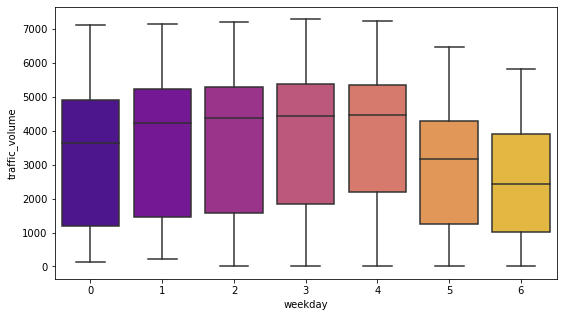

In [8]:
### PLOT TRAFFIC DISTRIBUTION IN EACH WEEKDAY ###

plt.figure(figsize=(9,5))
sns.boxplot(x=df.index.weekday, y=df.traffic_volume, palette='plasma')

plt.ylabel('traffic_volume'); plt.xlabel('weekday')

Text(0.5, 0, 'hour')

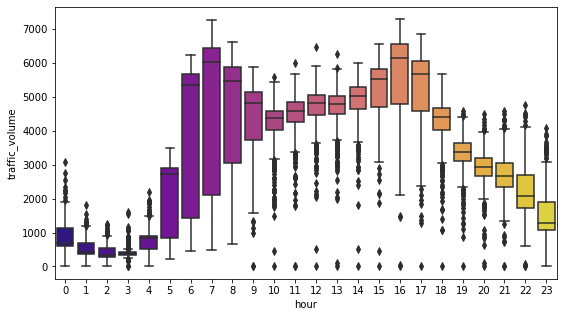

In [9]:
### PLOT TRAFFIC DISTRIBUTION IN EACH HOUR ###

plt.figure(figsize=(9,5))
sns.boxplot(x=df.index.hour, y=df.traffic_volume, palette='plasma')

plt.ylabel('traffic_volume'); plt.xlabel('hour')

In [10]:
### NUMERICAL ENCODE CATEGORICAL COLUMNS ###

map_col = dict()

X = df.select_dtypes(include=['object']).copy()
for i,cat in enumerate(X):
    X[cat] = df[cat].factorize()[0]
    map_col[cat] = i

X['month'] = df.index.month;  i += 1;  map_col['month'] = i
X['weekday'] = df.index.weekday;  i += 1;  map_col['weekday'] = i
X['hour'] = df.index.hour;  i += 1;  map_col['hour'] = i
X.shape

(24096, 6)

In [11]:
### UTILITY FUNCTION FOR 3D SEQUENCE GENERATION ###

def gen_seq(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [12]:
### GENERATE 3D SEQUENCES ###

sequence_length = 24*7

sequence_input = []
sequence_target = []

for seq in gen_seq(X, sequence_length, X.columns):
    sequence_input.append(seq)
    
for seq in gen_seq(df, sequence_length, ['traffic_volume']):
    sequence_target.append(seq)
    
sequence_input = np.asarray(sequence_input)
sequence_target = np.asarray(sequence_target)

sequence_input.shape, sequence_target.shape

((23928, 168, 6), (23928, 168, 1))

In [13]:
### UTILITY FUNCTION TO INSERT RANDOM MISSING INTERVALS ###

def drop_fill_pieces(sequence_input, sequence_target, missing_len, missing_val=np.nan, size=0.2):
    
    sequence_input = np.copy(sequence_input)
    sequence_target = np.copy(sequence_target)
    
    _id_seq = np.random.choice(range(len(sequence_target)), int(len(sequence_target)*size), replace=False)
    _id_time = np.random.randint(0,sequence_length-missing_len, int(len(sequence_target)*size))
    
    for i,t in zip(_id_seq, _id_time):
        sequence_input[i, t:t+missing_len, 
                       [map_col['holiday'], 
                        map_col['weather_main'],
                        map_col['weather_description']]] = -1
        sequence_target[i, t:t+missing_len, :] = missing_val
        
    sequence_input[:,:, 
                   [map_col['holiday'], 
                    map_col['weather_main'],
                    map_col['weather_description']]] += 1
    
    return sequence_input, sequence_target

In [14]:
### INSERT MISSING INTERVALS AT RANDOM ###

np.random.seed(33)

missing_len = 24
sequence_input, sequence_target_drop = drop_fill_pieces(sequence_input, sequence_target,
                                                        missing_len=missing_len, size=0.6)

sequence_input.shape, sequence_target_drop.shape

((23928, 168, 6), (23928, 168, 1))

In [15]:
### TRAIN TEST SPLIT ###

train_size = 0.8

sequence_input_train = sequence_input[:int(len(sequence_input)*train_size)]
sequence_input_test = sequence_input[int(len(sequence_input)*train_size):]
print(sequence_input_train.shape, sequence_input_test.shape)

sequence_target_train = sequence_target[:int(len(sequence_target)*train_size)]
sequence_target_test = sequence_target[int(len(sequence_target)*train_size):]
print(sequence_target_train.shape, sequence_target_test.shape)

sequence_target_drop_train = sequence_target_drop[:int(len(sequence_target_drop)*train_size)]
sequence_target_drop_test = sequence_target_drop[int(len(sequence_target_drop)*train_size):]
print(sequence_target_drop_train.shape, sequence_target_drop_test.shape)

(19142, 168, 6) (4786, 168, 6)
(19142, 168, 1) (4786, 168, 1)
(19142, 168, 1) (4786, 168, 1)


In [16]:
### UTILITY CLASS FOR SEQUENCES SCALING ###

class Scaler1D:
    
    def fit(self, X):
        self.mean = np.nanmean(np.asarray(X).ravel())
        self.std = np.nanstd(np.asarray(X).ravel())
        return self
        
    def transform(self, X):
        return (X - self.mean)/self.std
    
    def inverse_transform(self, X):
        return (X*self.std) + self.mean

In [17]:
### SCALE SEQUENCES AND MASK NANs ###

scaler_target = Scaler1D().fit(sequence_target_train)

sequence_target_train = scaler_target.transform(sequence_target_train)
sequence_target_test = scaler_target.transform(sequence_target_test)

sequence_target_drop_train = scaler_target.transform(sequence_target_drop_train)
sequence_target_drop_test = scaler_target.transform(sequence_target_drop_test)

mask_value = -999.
sequence_target_drop_train[np.isnan(sequence_target_drop_train)] = mask_value
sequence_target_drop_test[np.isnan(sequence_target_drop_test)] = mask_value

In [18]:
### UTILITY FUNCTIONS FOR VAE CREATION ###

latent_dim = 2

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def sampling(args):
    
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

def vae_loss(inp, original, out, z_log_sigma, z_mean):
    
    reconstruction = K.mean(K.square(original - out)) * sequence_length
    kl = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))

    return reconstruction + kl

def get_model():
    
    set_seed(33)
    
    ### encoder ###
    
    inp = Input(shape=(sequence_length, 1))
    inp_original = Input(shape=(sequence_length, 1))
    
    cat_inp = []
    cat_emb = []
    for cat,i in map_col.items():
        inp_c = Input(shape=(sequence_length,))
        if cat in ['holiday', 'weather_main', 'weather_description']:
            emb = Embedding(X[cat].max()+2, 6)(inp_c)
        else:
            emb = Embedding(X[cat].max()+1, 6)(inp_c)
        cat_inp.append(inp_c)
        cat_emb.append(emb)
    
    concat = Concatenate()(cat_emb + [inp])
    enc = LSTM(64)(concat)
    
    z = Dense(32, activation="relu")(enc)
        
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
            
    encoder = Model(cat_inp + [inp], [z_mean, z_log_sigma])
    
    ### decoder ###
    
    inp_z = Input(shape=(latent_dim,))

    dec = RepeatVector(sequence_length)(inp_z)
    dec = Concatenate()([dec] + cat_emb)
    dec = LSTM(64, return_sequences=True)(dec)
    
    out = TimeDistributed(Dense(1))(dec)
    
    decoder = Model([inp_z] + cat_inp, out)   
    
    ### encoder + decoder ###
    
    z_mean, z_log_sigma = encoder(cat_inp + [inp])
    z = Lambda(sampling)([z_mean, z_log_sigma])
    pred = decoder([z] + cat_inp)
    
    vae = Model(cat_inp + [inp, inp_original], pred)
    vae.add_loss(vae_loss(inp, inp_original, pred, z_log_sigma, z_mean))
    vae.compile(loss=None, optimizer=Adam(lr=1e-3))
    
    return vae, encoder, decoder

In [19]:
es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
vae, enc, dec = get_model()
vae.fit([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train, sequence_target_train], 
         batch_size=128, epochs=100, validation_split=0.2, shuffle=False, callbacks=[es])

Epoch 1/100
120/120 [==============================] - 36s 302ms/step - loss: 80.3598 - val_loss: 37.5229
Epoch 2/100
120/120 [==============================] - 36s 300ms/step - loss: 22.6669 - val_loss: 23.1471
Epoch 3/100
120/120 [==============================] - 40s 332ms/step - loss: 15.4416 - val_loss: 23.8763
Epoch 4/100
120/120 [==============================] - 32s 269ms/step - loss: 13.6259 - val_loss: 24.1615
Epoch 5/100
120/120 [==============================] - 32s 265ms/step - loss: 13.2095 - val_loss: 23.7290
Epoch 6/100
120/120 [==============================] - 32s 265ms/step - loss: 12.1795 - val_loss: 27.4268
Epoch 7/100
120/120 [==============================] - 32s 265ms/step - loss: 11.7454 - val_loss: 19.7928
Epoch 8/100
120/120 [==============================] - 32s 265ms/step - loss: 10.6105 - val_loss: 19.4873
Epoch 9/100
120/120 [==============================] - 32s 264ms/step - loss: 10.2637 - val_loss: 18.9843
Epoch 10/100
120/120 [========================

In [20]:
### COMPUTE RECONSTRUCTION ###

vae = Model(vae.input[:-1], vae.output)

reconstruc_train = scaler_target.inverse_transform(
    vae.predict([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train]))
reconstruc_test = scaler_target.inverse_transform(
    vae.predict([sequence_input_test[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_test]))

reconstruc_train.shape, reconstruc_test.shape

((19142, 168, 1), (4786, 168, 1))

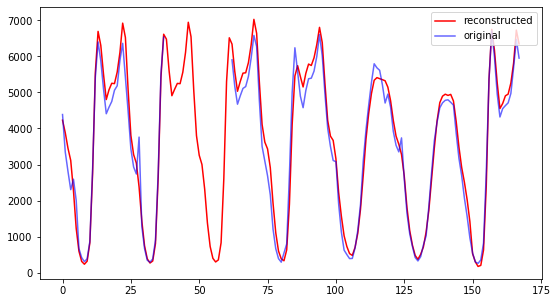

In [21]:
### PLOT REAL vs RECONSTRUCTION ###

id_seq = 100

seq = np.copy(sequence_target_drop_test[id_seq])
seq[seq == mask_value] = np.nan
seq = scaler_target.inverse_transform(seq)

plt.figure(figsize=(9,5))
plt.plot(reconstruc_test[id_seq], label='reconstructed', c='red')
plt.plot(seq, c='blue', label='original', alpha=0.6)
plt.legend()

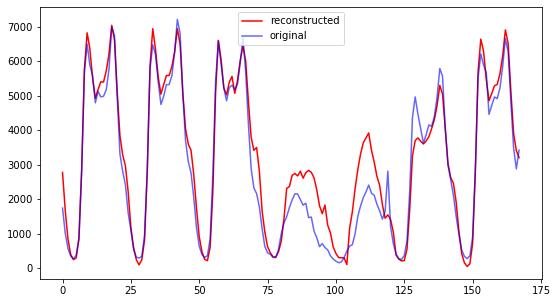

In [22]:
### PLOT REAL vs RECONSTRUCTION ###

id_seq = 800

seq = np.copy(sequence_target_drop_test[id_seq])
seq[seq == mask_value] = np.nan
seq = scaler_target.inverse_transform(seq)

plt.figure(figsize=(9,5))
plt.plot(reconstruc_test[id_seq], label='reconstructed', c='red')
plt.plot(seq, c='blue', label='original', alpha=0.6)
plt.legend()

In [23]:
### COMPUTE PERFORMANCES ON TRAIN ###

mask = (sequence_target_drop_train == mask_value)

print('reconstruction error on entire sequences:',
    mse(np.squeeze(reconstruc_train, -1), np.squeeze(sequence_target_train, -1), squared=False))
print('reconstruction error on missing sequences:',
    mse(reconstruc_train[mask].reshape(-1,missing_len), sequence_target_train[mask].reshape(-1,missing_len), squared=False))

reconstruction error on entire sequences: 4045.475900775017
reconstruction error on missing sequences: 4049.877372703149


In [24]:
### COMPUTE PERFORMANCES ON TEST ###

mask = (sequence_target_drop_test == mask_value)

print('reconstruction error on entire sequences:',
    mse(np.squeeze(reconstruc_test, -1), np.squeeze(sequence_target_test, -1), squared=False))
print('reconstruction error on missing sequences:',
    mse(reconstruc_test[mask].reshape(-1,missing_len), sequence_target_test[mask].reshape(-1,missing_len), squared=False))

reconstruction error on entire sequences: 4064.68189234263
reconstruction error on missing sequences: 4069.3574954226733


In [25]:
### GET LATENT REPRESENTATION ON TRAIN DATA ###

enc_pred, _ = enc.predict([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train])
enc_pred.shape

(19142, 2)

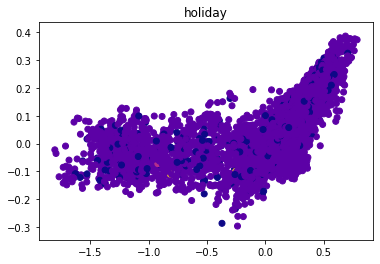

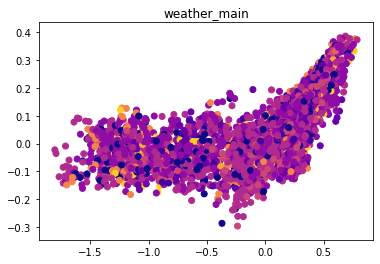

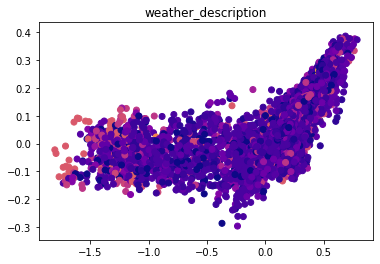

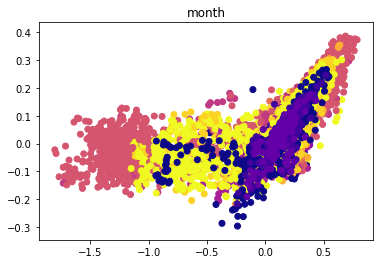

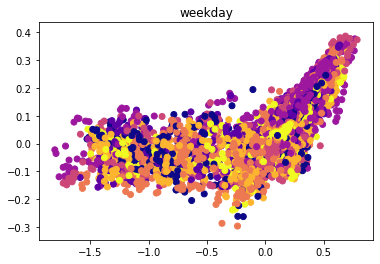

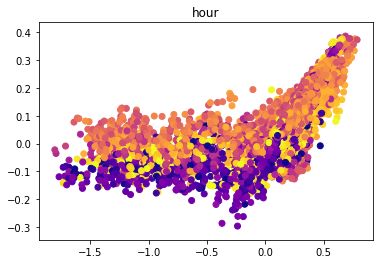

In [26]:
### PLOT LATENT REPRESENTATION ###

for cat,i in map_col.items():
    plt.scatter(enc_pred[:,0], enc_pred[:,1], c=sequence_input_train[:,sequence_length//2,i], cmap='plasma')
    plt.title(cat); plt.show()

In [27]:
### GENERATE RANDOM PERMUTATION ###

np.random.seed(33)

id_seq = 3333

_X = np.random.normal(enc_pred[id_seq,0], 3, 10)
_Y = np.random.normal(enc_pred[id_seq,1], 3, 10)
_cat_input = [sequence_input_train[[id_seq],:,i] for cat,i in map_col.items()]

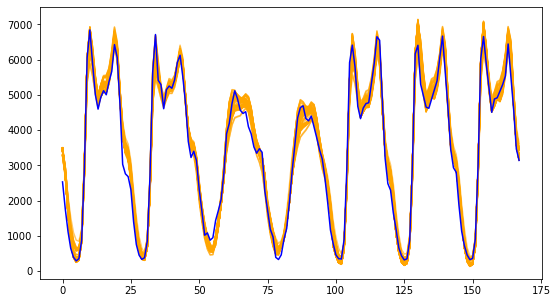

In [28]:
### PLOT RANDOM PERMUTATION ###

plt.figure(figsize=(9,5))
        
for x in _X:
    for y in _Y:
        dec_pred = dec.predict([np.asarray([[x,y]])] + _cat_input)
        plt.plot(scaler_target.inverse_transform(dec_pred[0]), c='orange', alpha=0.6)
plt.plot(scaler_target.inverse_transform(sequence_target_train[id_seq]), c='blue')